# Climate skill at 1&deg;
Time-mean RMSE and bias

In [1]:
from collections import namedtuple
import re
from string import ascii_lowercase
from itertools import product

import wandb
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

from utils import wandb_to_beaker_experiment, wandb_to_beaker_result, get_scalar_metrics, savefig, DPI, FONTSIZE
from constants import INFERENCE_COMPARISON_1DEG, WANDB_ENTITY, SECONDS_PER_DAY, WANDB_PROJECT

In [2]:
wandb_api = wandb.Api()

In [3]:
WandbRun = namedtuple('WandbRun', ['project', 'id'])
EvalVar = namedtuple('EvalVar', ['name', 'conversion_factor', 'long_name', 'units'])
EvalMetric = namedtuple('EvalMetric', ['name', 'long_name', 'units'])

In [4]:
TIME_MEAN_EVAL_VARS = [
    EvalVar('TMP2m', None, '2-meter temperature', 'K'),
    EvalVar('PRATEsfc', SECONDS_PER_DAY, 'surface precipitation rate', 'mm/day'),
    EvalVar('total_water_path', None, 'total water path', 'mm'),
    EvalVar('h500', None, '500hPa height', 'm')
]
TIME_MEAN_METRICS = [
    EvalMetric("inference/time_mean/bias/{varname}", "Global-mean bias", None),
    EvalMetric("inference/time_mean/rmse/{varname}", "Global RMSE of time-mean error", None),
    EvalMetric("inference/annual/r2/{varname}_gen", r"$R^2$ of global- and annual-mean series", '-'),
]

In [5]:
all_metrics = [(eval_var, eval_metric) for eval_var, eval_metric in product(TIME_MEAN_EVAL_VARS, TIME_MEAN_METRICS)]
all_metric_names = [
    eval_metric.name.format(varname=eval_var.name)
    for eval_var, eval_metric in all_metrics
]
print(f"{all_metric_names=}")

all_metric_names=['inference/time_mean/bias/TMP2m', 'inference/time_mean/rmse/TMP2m', 'inference/annual/r2/TMP2m_gen', 'inference/time_mean/bias/PRATEsfc', 'inference/time_mean/rmse/PRATEsfc', 'inference/annual/r2/PRATEsfc_gen', 'inference/time_mean/bias/total_water_path', 'inference/time_mean/rmse/total_water_path', 'inference/annual/r2/total_water_path_gen', 'inference/time_mean/bias/h500', 'inference/time_mean/rmse/h500', 'inference/annual/r2/h500_gen']


In [6]:
metrics = {}
for duration_name, duration_group in INFERENCE_COMPARISON_1DEG.items():
    for run_group_name, run_group in duration_group.items():
        for ic_name, run_id in run_group.items():
            if '-' in ic_name:
                ic_name = ic_name.split('-')[1]
            full_key = '/'.join([duration_name, run_group_name, ic_name])
            print(f"Getting metrics for {full_key=}.")
            run = wandb_api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_id}")
            metrics[full_key] = get_scalar_metrics(run, all_metric_names)

Getting metrics for full_key='10yr/ACE2-ERA5/IC0'.
Getting metrics for full_key='10yr/ACE2-ERA5/IC1'.
Getting metrics for full_key='10yr/ACE2-ERA5/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS0/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS0/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS0/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS1/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS1/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS1/IC2'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS2/IC0'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS2/IC1'.
Getting metrics for full_key='10yr/ACE2-SHiELD-RS2/IC2'.
Getting metrics for full_key='10yr/SHiELD-reference/IC0'.
Getting metrics for full_key='10yr/ACE-climSST/IC0'.
Getting metrics for full_key='10yr/ACE-climSST/IC1'.
Getting met

In [7]:
ic_key = '/IC[0-9]*$'
duration_key = '^[0-9]*yr/'
das = []
for run_name, run_metrics in metrics.items():
    run_coords = {}
    ic_match = re.search(ic_key, run_name)
    if ic_match:
        trimmed_run_name = run_name[0:ic_match.span()[0]]
        run_coords['IC'] = [ic_match.group().strip('/')]
    else:
        trimmed_run_name = run_name
    duration_match = re.search(duration_key, trimmed_run_name)
    if duration_match:
        trimmed_run_name = trimmed_run_name[duration_match.span()[1]:]
        run_coords['duration'] = [duration_match.group().strip('/')]
    else:
        trimmed_run_name = trimmed_run_name
    metric_names, metric_values = zip(*run_metrics.items())
    run_da = xr.DataArray(list(metric_values), dims='metric', coords={'metric': list(metric_names)}, name=trimmed_run_name)
    das.append(run_da.expand_dims(run_coords))
all_metrics_ds = xr.merge(das) 

In [8]:
plt.rc('font', size=FONTSIZE)
plt.rc('axes', titlesize=FONTSIZE)
plt.rc('axes', labelsize=(FONTSIZE - 2))
plt.rc('xtick', labelsize=(FONTSIZE - 4))
plt.rc('ytick', labelsize=(FONTSIZE - 4))
plt.rc('figure', dpi=DPI)

cmap_name = 'viridis_r'
n_colors_base = 5 # ACE2-ERA5, ACE2-SHiELD, SHiELD-reference, ACE-climSST, ERA5 vs SHiELD
i_color_repeat = 1
n_repeats = 4 # 4 ACE2-SHiELD seeds
base_color_scheme = plt.get_cmap(cmap_name)(np.linspace(0, 1, n_colors_base))
repeated_color = np.tile(base_color_scheme[i_color_repeat][None, :], (n_repeats - 1, 1))
color_scheme = np.insert(base_color_scheme, i_color_repeat, repeated_color, axis=0)

FIGSIZE = [1.27 * dim for dim in [5.5, 2.5]] # should be [5.5, 2.5], but need to scale up for unknown font size reasons

In [9]:
def plot_bars(metrics_ds, plot_vars, plot_metric, figsize=FIGSIZE, convert=True, ylim=None):
    nrows, ncols = 1, len(plot_vars)
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=False, figsize=figsize)
    if len(plot_vars) == 1:
        # if only plotting one variable
        axes = np.array([axes])
    for i, variable in enumerate(plot_vars):
        full_metric_name = plot_metric.name.format(varname=variable.name)
        ax = axes[i]
        metric_ds = metrics_ds.sel(metric=full_metric_name)
        if convert and variable.conversion_factor is not None:
            metric_ds = metric_ds * variable.conversion_factor
        mean = metric_ds.mean('IC')
        ylower = (mean - metric_ds.min('IC'))
        yupper = (metric_ds.max('IC') - mean)
        yerr = np.vstack([ylower.to_array().to_numpy(), yupper.to_array().to_numpy()])
        plot_mean = (
            mean
            .to_array(dim='run_group', name=full_metric_name)
            .drop_vars(['metric', 'duration'], errors=False)
        )
        plot_mean.to_series().plot.bar(
            yerr=yerr,
            ax=ax,
            color=color_scheme,
            error_kw=dict(
                capsize=2,
                linewidth=1,
                ecolor='gray'),
            linewidth=0.5,
            edgecolor='gray',
            legend=False
        )
        ax.plot([-1, len(plot_mean)], [0, 0], 'k-')
        ax.set_xlabel(None)
        units = variable.units if plot_metric.units is None else plot_metric.units
        ax.set_ylabel(f"{plot_metric.long_name} [{units}]", fontsize='x-small')
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(axis='y', which='both')
        ax.set_title(f"{ascii_lowercase[i]}) {variable.long_name}")
        ax.set_xticklabels([varname for varname in mean.data_vars], rotation=75)
    fig.tight_layout()
    return fig

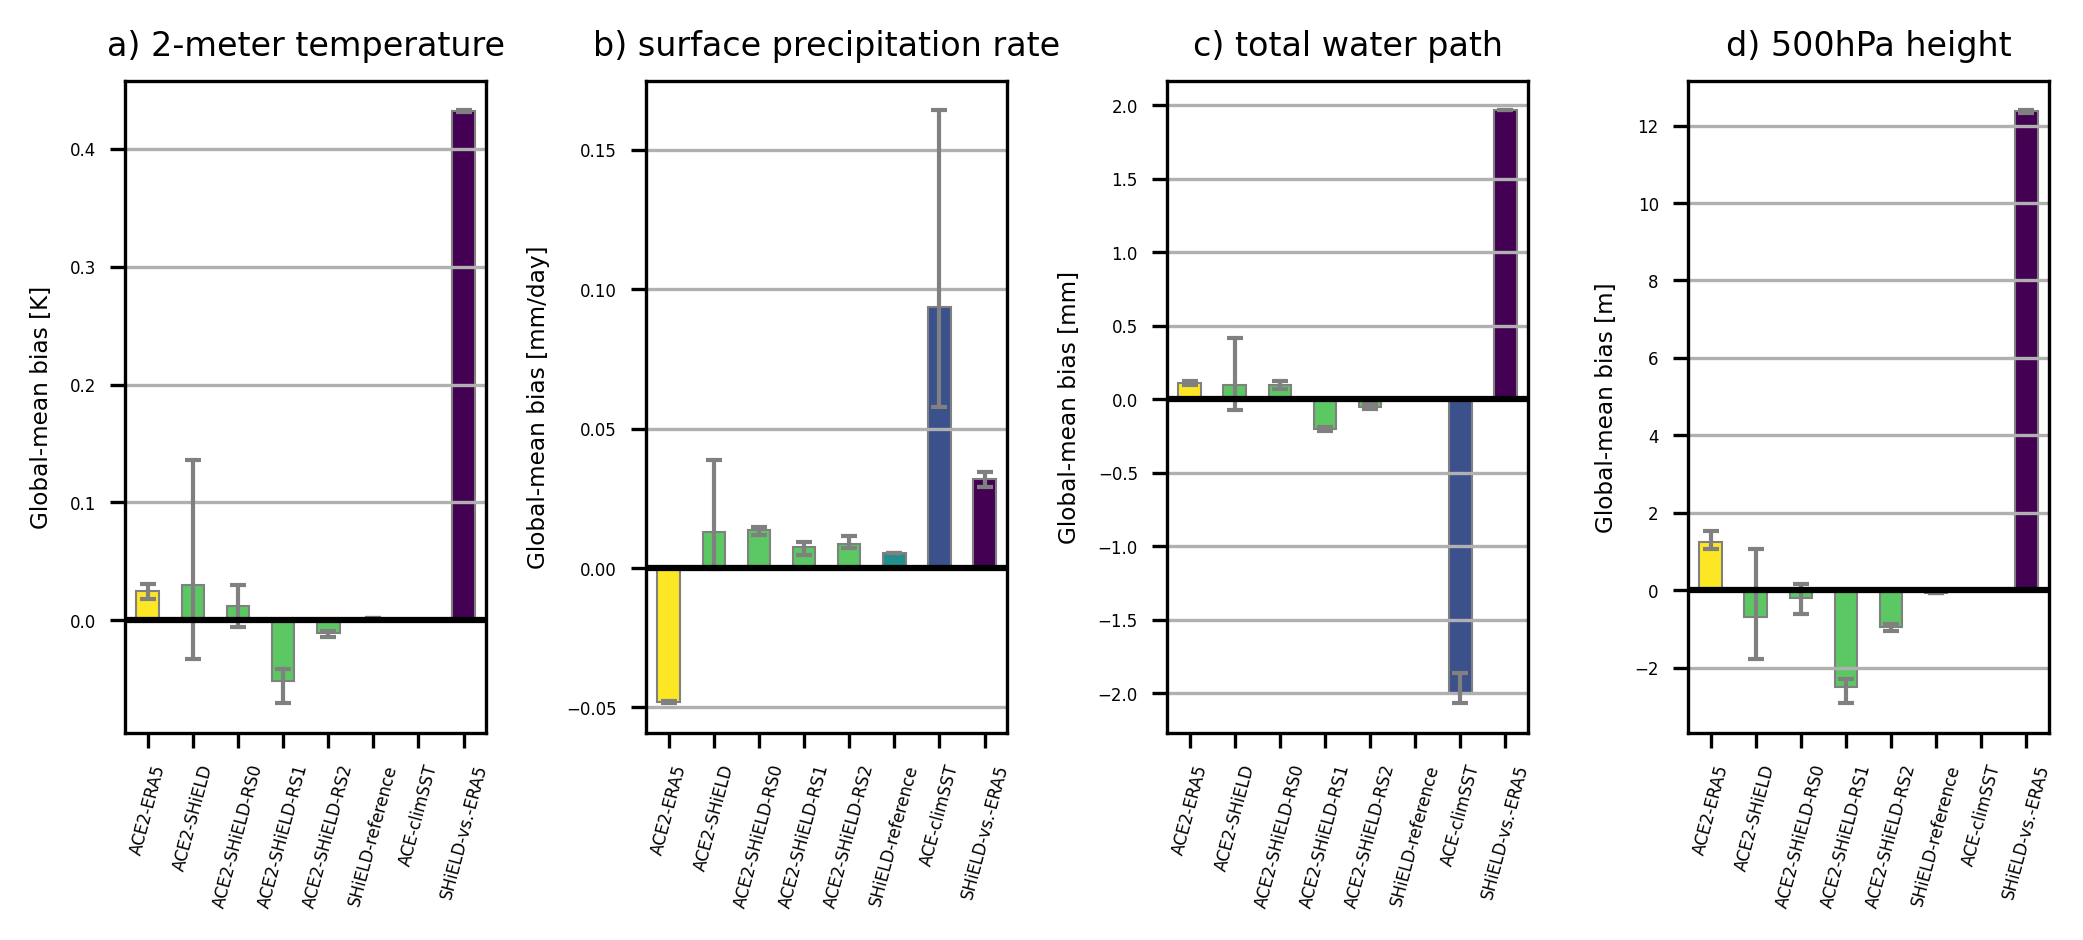

In [10]:
plot_metric = TIME_MEAN_METRICS[0] # bias
plot_vars = TIME_MEAN_EVAL_VARS
duration = '10yr'
fig = plot_bars(all_metrics_ds.sel(duration=duration), plot_vars, plot_metric)

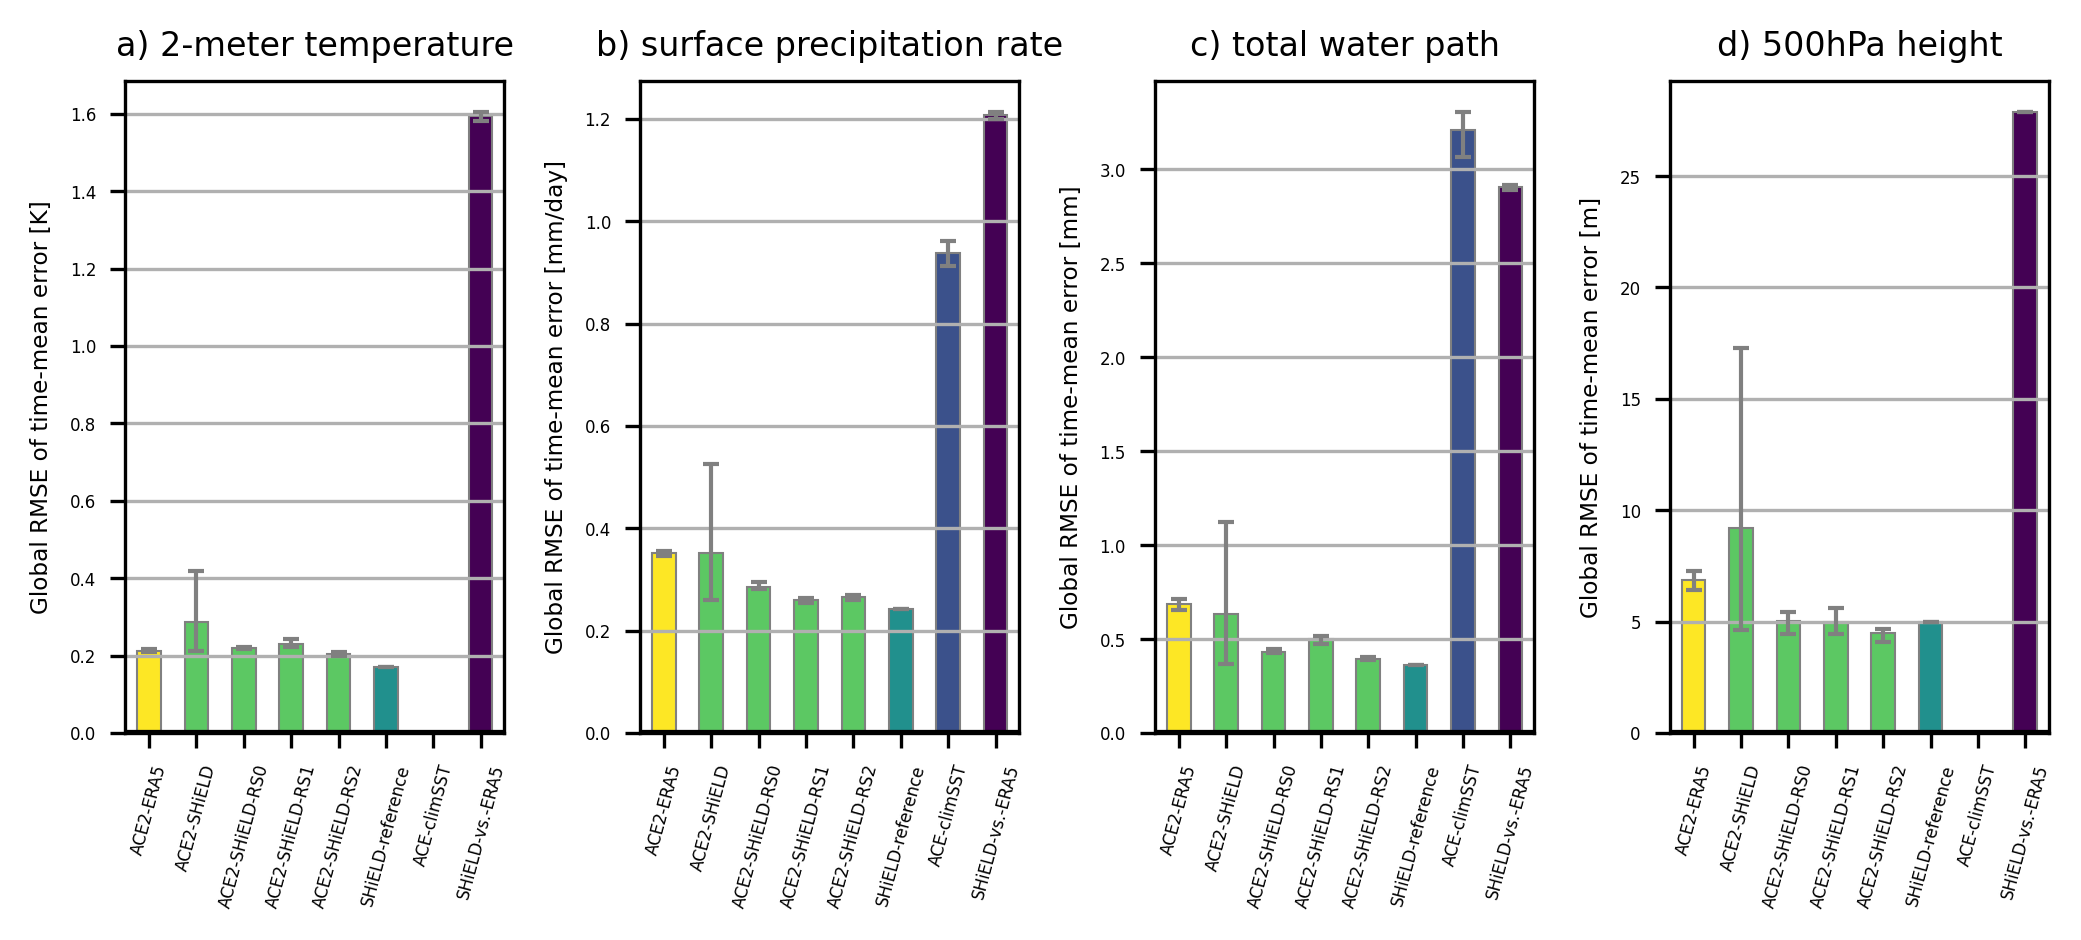

In [11]:
plot_metric = TIME_MEAN_METRICS[1] # RMSE
plot_vars = TIME_MEAN_EVAL_VARS
duration = '10yr'
fig = plot_bars(all_metrics_ds.sel(duration=duration), plot_vars, plot_metric)
savefig(fig, 'climate_skill_1deg_time_mean_RMSE_10yr.png')

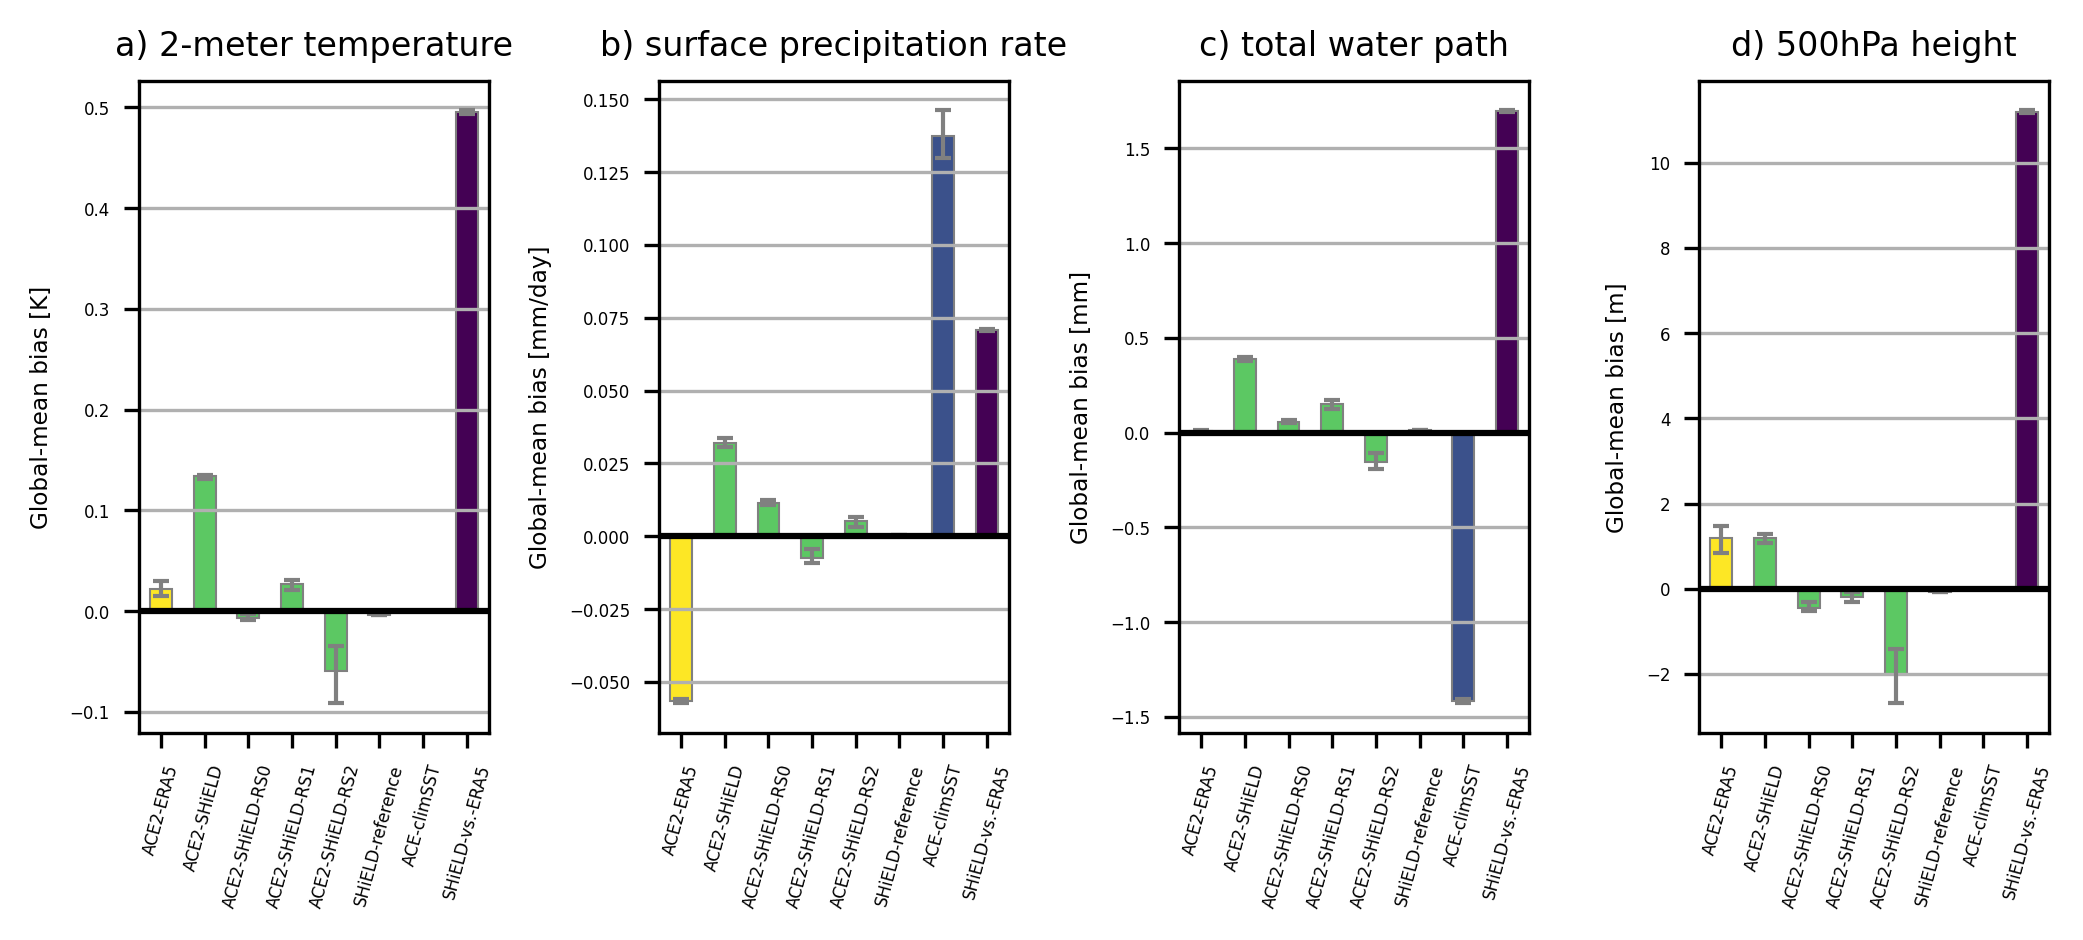

In [12]:
plot_metric = TIME_MEAN_METRICS[0] # bias
plot_vars = TIME_MEAN_EVAL_VARS
duration = '81yr'
fig = plot_bars(all_metrics_ds.sel(duration=duration), plot_vars, plot_metric)

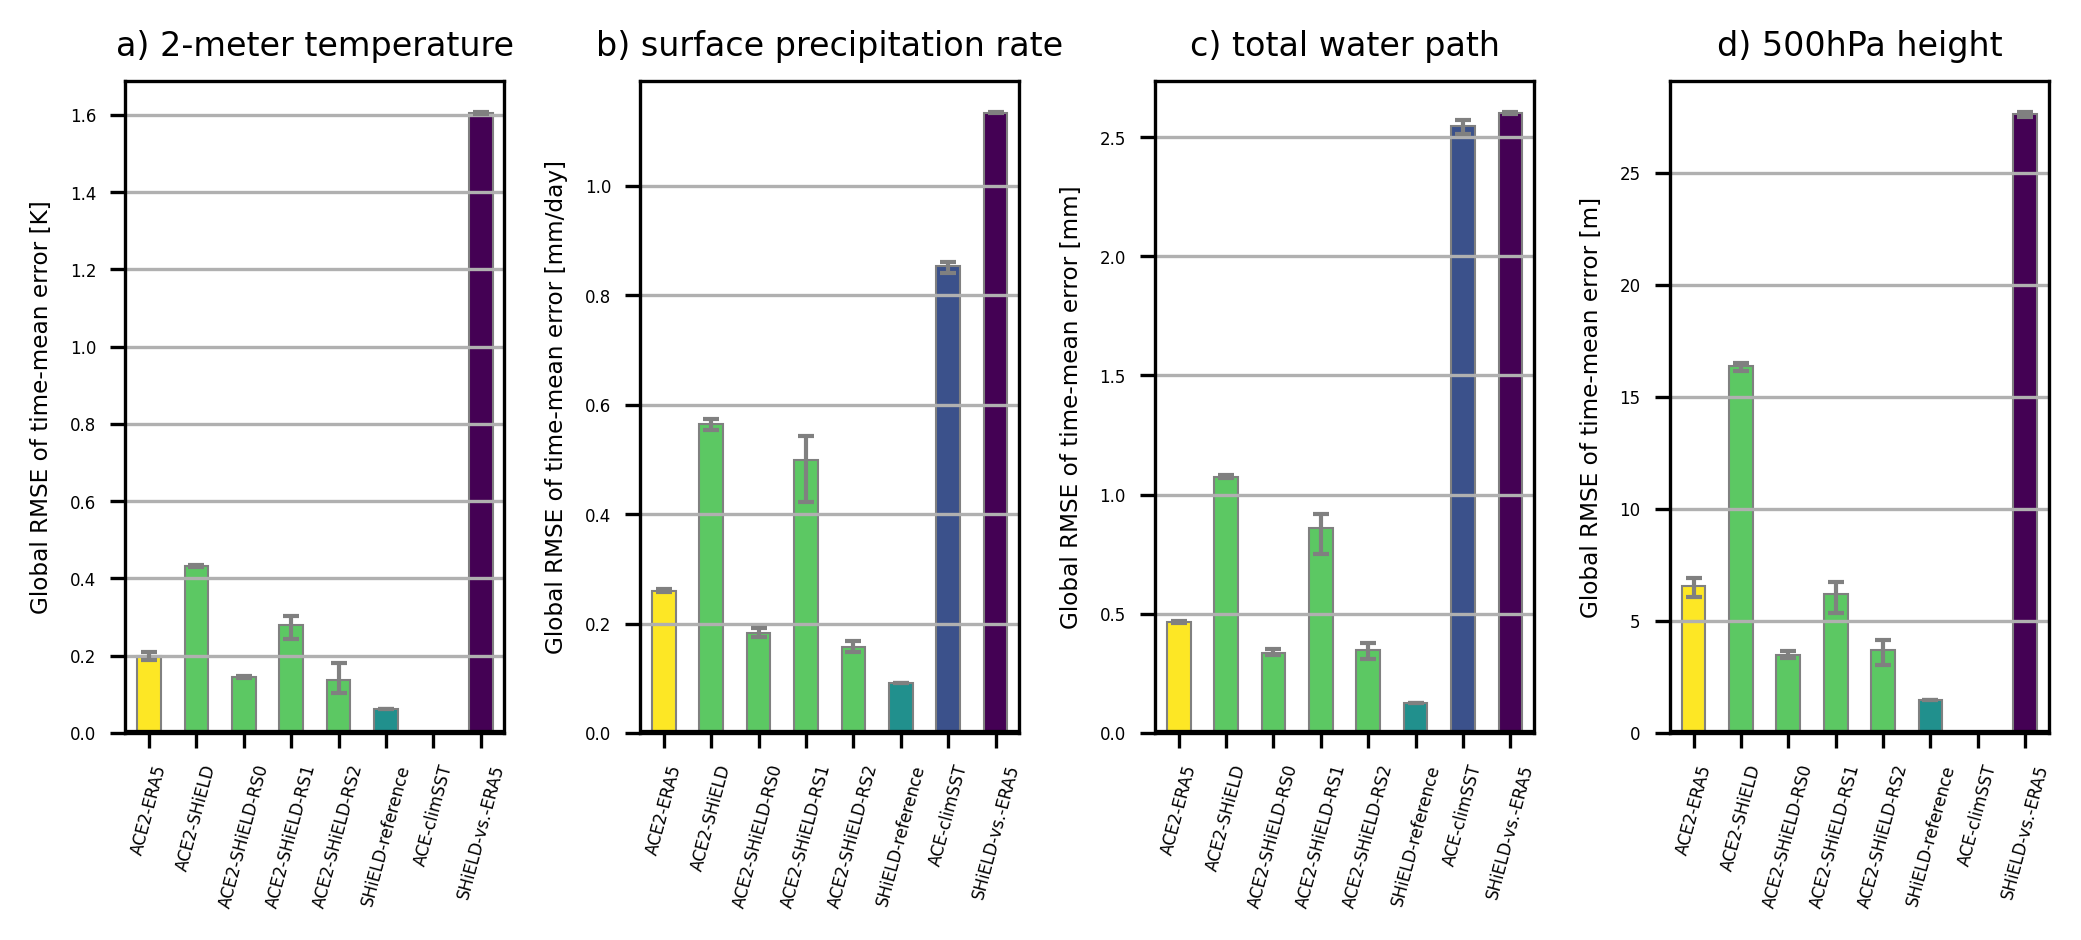

In [13]:
plot_metric = TIME_MEAN_METRICS[1] # RMSE
plot_vars = TIME_MEAN_EVAL_VARS
duration = '81yr'
fig = plot_bars(all_metrics_ds.sel(duration=duration), plot_vars, plot_metric)